## Поиск источника девиаций по данным Splunk

In [22]:
import splunklib
import splunklib.client as client
import splunklib.results as results

import datetime as dt
from time import sleep

import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import matplotlib as mpl
import matplotlib.pyplot as plt

import lowess as lo

#%matplotlib notebook

In [2]:
#Подключение к Splunk

HOST = "splunk-search01.roamability.com"
PORT = 8089
USERNAME = "pavel"
PASSWORD = "O777ver7k1"
# Create a Service instance and log in 
service = client.connect(
    host=HOST,
    port=PORT,
    username=USERNAME,
    password=PASSWORD)

In [3]:
#Создаем необходимые процедуры

log_level = 0

def outLog(message, level=1):
    if(level <= log_level):
        print (message)
        sys.stdout.flush()

def FormatSplunkEngineDate(dt): return dt.strftime("%Y-%m-%dT%H:%M:%S")

In [48]:
#Указываем время, запрос и запускаем запрос

dateFrom = dt.datetime.strptime('2018-06-20T00:00:00', '%Y-%m-%dT%H:%M:%S')
dateTo = dt.datetime.strptime('2018-06-21T00:00:00', '%Y-%m-%dT%H:%M:%S')
searchquery_export =\
'''
search index=sdr (4250196* OR 26006*) PROTOCOL=S6a ANS_RES_CODE=2001
| eval CODE_TEMP=case(isnotnull(ANS_RES_CODE),ANS_RES_CODE,isnull(ANS_RES_CODE), ANS_EXP_RES_CODE, isnull(ANS_EXP_RES_CODE), EXP_RES_CODE, isnull(EXP_RES_CODE), RES_CODE)
| eval CODE=if(isnotnull(CODE_TEMP), CODE_TEMP, "PUR_NOR") | eval CUSTOMER=coalesce(THIRD_PARTY,MVNO)
| Timechart span=15m count by CUSTOMER  | table * | sort by _time
'''

In [49]:
## Исправленный вариант обращения к Splunk на основе:
#http://docs.splunk.com/DocumentationStatic/PythonSDK/1.6.3/client.html#splunklib.client.Job.results
#Кол-во записей в результате на основе:
#https://answers.splunk.com/answers/237043/how-to-submit-a-splunk-python-sdk-query-with-a-res.html

bEchoTime = False

sfrom = dateFrom if  bEchoTime else FormatSplunkEngineDate(dateFrom) 
sto = dateTo if  bEchoTime else FormatSplunkEngineDate(dateTo)

kwargs_export = {"earliest_time": sfrom,
                 "latest_time":sto ,
                 "search_mode": "normal",
                 #"output_mode":"JSON",
                 #"rf" : fields,
                 "supports_multivalues":True
                 }

kwargs_paginate = {"count": 1000  # Get sets of count results at a time
                   ,"offset": 0  # Start at result 0
                  }

job = service.jobs.create(searchquery_export, **kwargs_export)

while not job.is_done():
    sleep(.2)

rr = results.ResultsReader(job.results(**kwargs_paginate))

outputResult = list()
i=0

for result in rr:
            if isinstance(result, dict):
                outputResult.append(result)
assert rr.is_preview == False

# Получаем исходные данные для анализа с датой и временем в индексе

df_source=DataFrame(outputResult,dtype='int64')
df_source['rep_date']=pd.to_datetime(df_source['_time'])
df_source.drop(['_time','_span'],axis=1,inplace=True)
df_source=df_source.set_index('rep_date')

print("Найдено записей:\n{}\n".format(df_source.count()))
df_source.tail()

Найдено записей:
C9              96
MB              96
Maxcom          96
Mondicon        96
NAKA            96
OTHER           96
PuertoSeguro    96
Rewicom         96
Roamability     96
Telzar          96
Tinklabs        96
dtype: int64



,C9,MB,Maxcom,Mondicon,NAKA,OTHER,PuertoSeguro,Rewicom,Roamability,Telzar,Tinklabs
rep_date,,,,,,,,,,,
2018-06-20 20:45:00,688,404,2,165,2568,3,255,1,301,3451,299
2018-06-20 21:00:00,631,373,0,87,2553,4,171,1,333,3402,351
2018-06-20 21:15:00,686,349,0,51,2501,1,155,1,314,3332,378
2018-06-20 21:30:00,547,385,5,73,2252,15,162,0,272,3469,394
2018-06-20 21:45:00,632,231,0,41,2066,1,180,0,311,3323,337


['C9', 'MB', 'Maxcom', 'Mondicon', 'NAKA', 'OTHER', 'PuertoSeguro', 'Rewicom', 'Roamability', 'Telzar', 'Tinklabs']


,C9,C9_lo,C9_std_first_step,C9_adj,C9_adj_first_step,C9_std
rep_date,,,,,,
2018-06-19 22:00:00,629.0,656.381575,50.136813,656.381575,629.0,50.136813
2018-06-19 22:15:00,706.0,689.596092,51.655268,689.596092,706.0,51.655268
2018-06-19 22:30:00,739.0,696.034316,72.681628,696.034316,739.0,72.681628
2018-06-19 22:45:00,760.0,684.174035,73.757808,684.174035,760.0,73.757808
2018-06-19 23:00:00,695.0,666.140673,79.777257,666.140673,695.0,79.777257


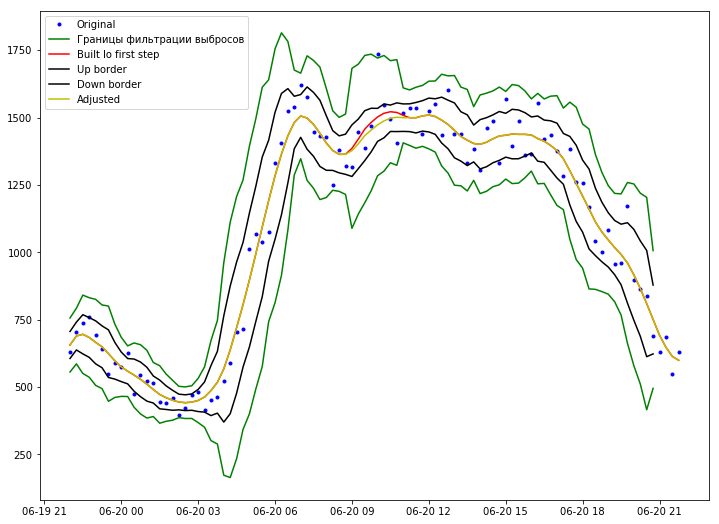

,MB,MB_lo,MB_std_first_step,MB_adj,MB_adj_first_step,MB_std
rep_date,,,,,,
2018-06-19 22:00:00,235.0,224.156483,32.368194,224.156483,235.0,32.368194
2018-06-19 22:15:00,188.0,200.356695,36.339602,200.356695,188.0,36.339602
2018-06-19 22:30:00,185.0,192.513981,34.374686,192.513981,185.0,34.374686
2018-06-19 22:45:00,151.0,191.110899,32.425464,191.110899,151.0,32.425464
2018-06-19 23:00:00,162.0,190.443425,27.978308,190.443425,162.0,27.978308


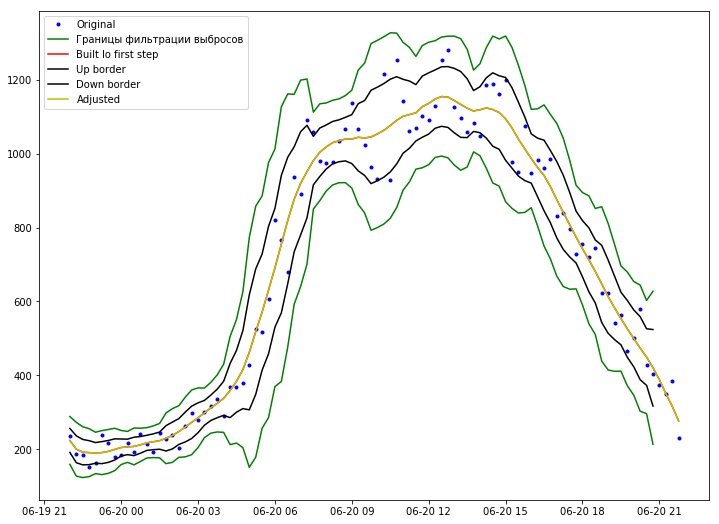

,Maxcom,Maxcom_lo,Maxcom_std_first_step,Maxcom_adj,Maxcom_adj_first_step,Maxcom_std
rep_date,,,,,,
2018-06-19 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2018-06-19 22:15:00,0.0,0.0,0.0,0.0,0.0,0.0
2018-06-19 22:30:00,0.0,0.0,0.0,0.0,0.0,0.0
2018-06-19 22:45:00,0.0,0.0,0.0,0.0,0.0,0.0
2018-06-19 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0


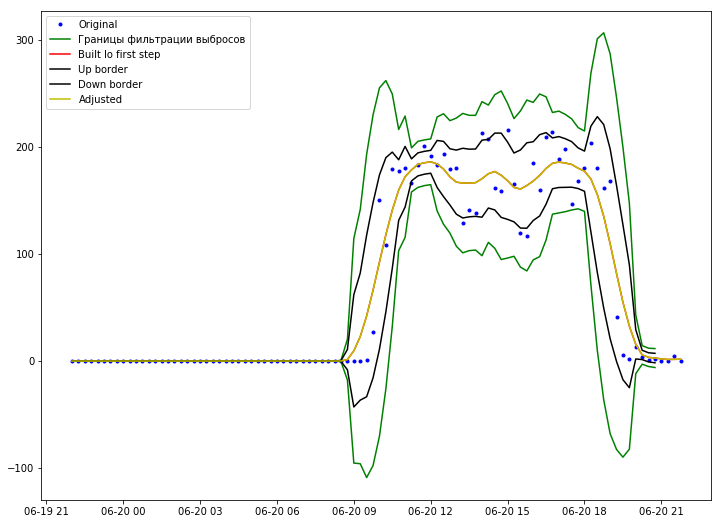

,Mondicon,Mondicon_lo,Mondicon_std_first_step,Mondicon_adj,Mondicon_adj_first_step,Mondicon_std
rep_date,,,,,,
2018-06-19 22:00:00,102.0,77.160289,35.442912,77.160289,102.0,35.442912
2018-06-19 22:15:00,62.0,87.244672,38.198167,87.244672,62.0,38.198167
2018-06-19 22:30:00,72.0,100.760331,35.564161,100.760331,72.0,35.564161
2018-06-19 22:45:00,145.0,110.877138,33.120721,110.877138,145.0,33.120721
2018-06-19 23:00:00,128.0,115.231542,35.166695,115.231542,128.0,35.166695


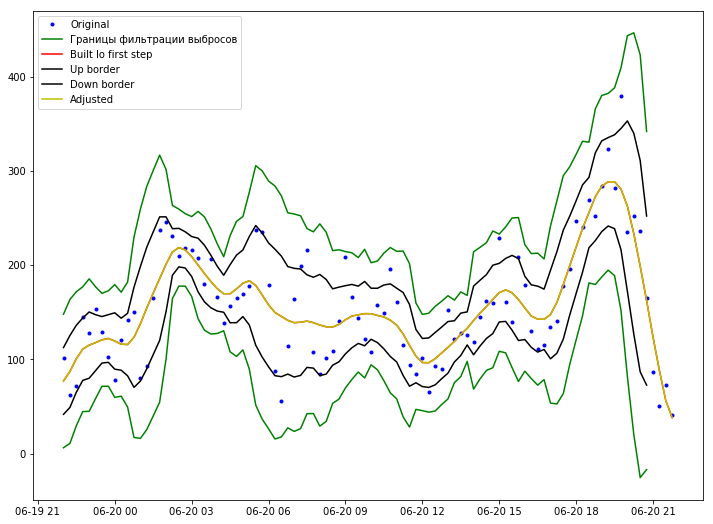

,NAKA,NAKA_lo,NAKA_std_first_step,NAKA_adj,NAKA_adj_first_step,NAKA_std
rep_date,,,,,,
2018-06-19 22:00:00,2124.0,2141.827749,68.280305,2141.827749,2124.0,68.280305
2018-06-19 22:15:00,2106.0,2123.702836,72.831312,2123.702836,2106.0,72.831312
2018-06-19 22:30:00,2184.0,2096.301786,73.038476,2096.301786,2184.0,73.038476
2018-06-19 22:45:00,2050.0,2073.903645,68.903141,2073.903645,2050.0,68.903141
2018-06-19 23:00:00,2007.0,2058.224552,67.487565,2058.224552,2007.0,67.487565


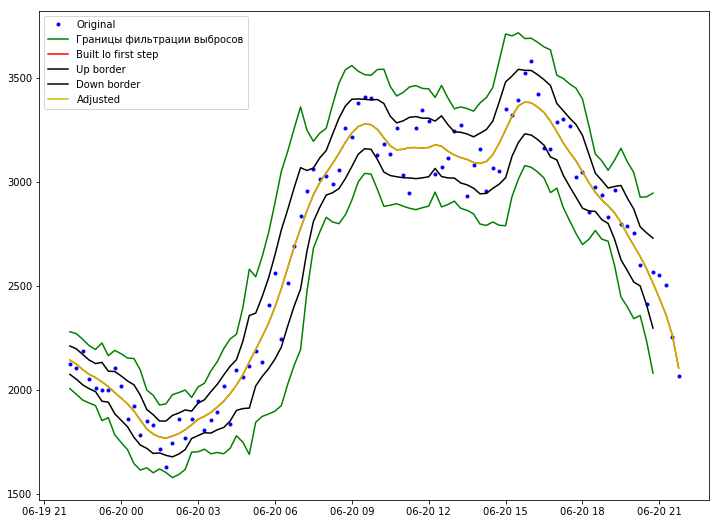

,OTHER,OTHER_lo,OTHER_std_first_step,OTHER_adj,OTHER_adj_first_step,OTHER_std
rep_date,,,,,,
2018-06-19 22:00:00,15.0,12.302551,6.572671,12.302551,15.0,6.572671
2018-06-19 22:15:00,6.0,7.630465,6.123724,7.630465,6.0,6.123724
2018-06-19 22:30:00,0.0,4.611060,5.744563,4.611060,0.0,5.744563
2018-06-19 22:45:00,0.0,2.627107,5.423165,2.627107,0.0,5.423165
2018-06-19 23:00:00,0.0,1.302752,2.100170,1.256881,0.0,2.121320


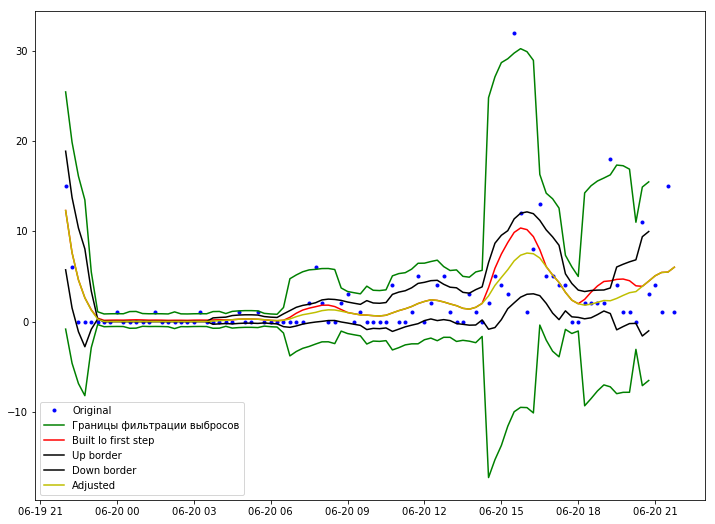

,PuertoSeguro,PuertoSeguro_lo,PuertoSeguro_std_first_step,PuertoSeguro_adj,PuertoSeguro_adj_first_step,PuertoSeguro_std
rep_date,,,,,,
2018-06-19 22:00:00,167.0,150.083818,21.993181,150.083818,167.0,21.993181
2018-06-19 22:15:00,130.0,152.110347,21.425841,152.110347,130.0,21.425841
2018-06-19 22:30:00,155.0,153.527620,19.599563,153.527620,155.0,19.599563
2018-06-19 22:45:00,148.0,153.522109,18.623622,153.522109,148.0,18.623622
2018-06-19 23:00:00,189.0,151.234163,21.420951,151.234163,189.0,21.420951


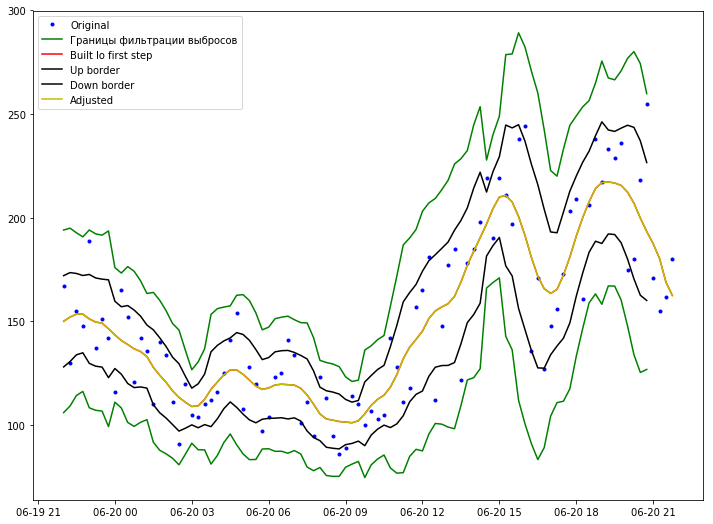

,Rewicom,Rewicom_lo,Rewicom_std_first_step,Rewicom_adj,Rewicom_adj_first_step,Rewicom_std
rep_date,,,,,,
2018-06-19 22:00:00,0.0,1.596348,2.167948,1.596348,0.0,2.167948
2018-06-19 22:15:00,4.0,2.508658,2.000000,2.508658,4.0,2.000000
2018-06-19 22:30:00,4.0,2.887566,1.976047,2.887566,4.0,1.976047
2018-06-19 22:45:00,5.0,2.838606,2.065879,2.838606,5.0,2.065879
2018-06-19 23:00:00,1.0,2.679773,1.832251,2.679773,1.0,1.832251


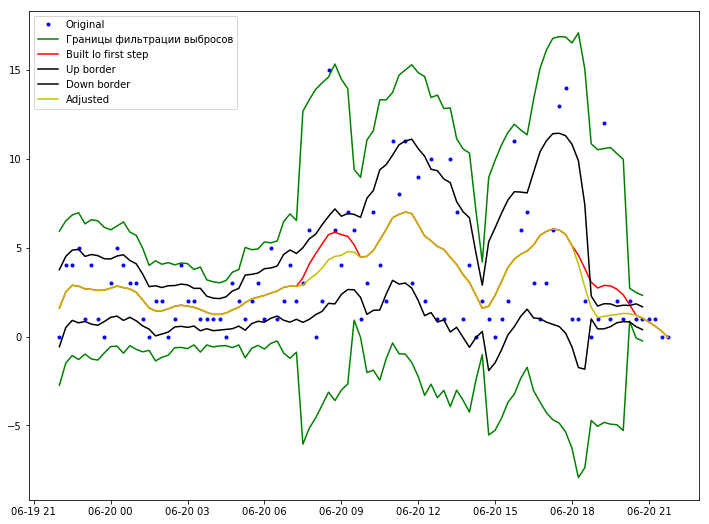

,Roamability,Roamability_lo,Roamability_std_first_step,Roamability_adj,Roamability_adj_first_step,Roamability_std
rep_date,,,,,,
2018-06-19 22:00:00,208.0,163.712017,57.421250,163.712017,208.0,57.421250
2018-06-19 22:15:00,72.0,129.787029,55.762592,129.787029,72.0,55.762592
2018-06-19 22:30:00,93.0,106.622302,51.662365,106.622302,93.0,51.662365
2018-06-19 22:45:00,78.0,91.168987,48.458377,91.168987,78.0,48.458377
2018-06-19 23:00:00,80.0,80.066405,11.940328,80.066405,80.0,11.940328


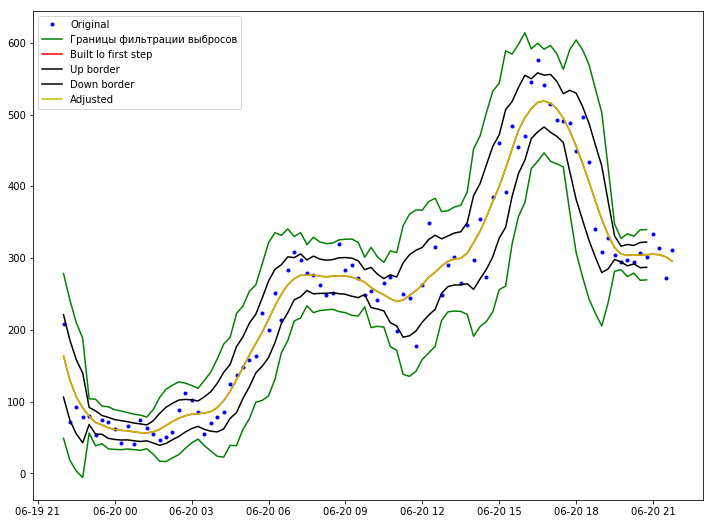

,Telzar,Telzar_lo,Telzar_std_first_step,Telzar_adj,Telzar_adj_first_step,Telzar_std
rep_date,,,,,,
2018-06-19 22:00:00,3110.0,3253.583757,132.820556,3253.583757,3110.0,132.820556
2018-06-19 22:15:00,3463.0,3275.757628,149.273909,3275.757628,3463.0,149.273909
2018-06-19 22:30:00,3312.0,3260.036474,145.976841,3260.036474,3312.0,145.976841
2018-06-19 22:45:00,3229.0,3259.690858,162.796927,3259.690858,3229.0,162.796927
2018-06-19 23:00:00,3203.0,3273.197466,148.699541,3273.197466,3203.0,148.699541


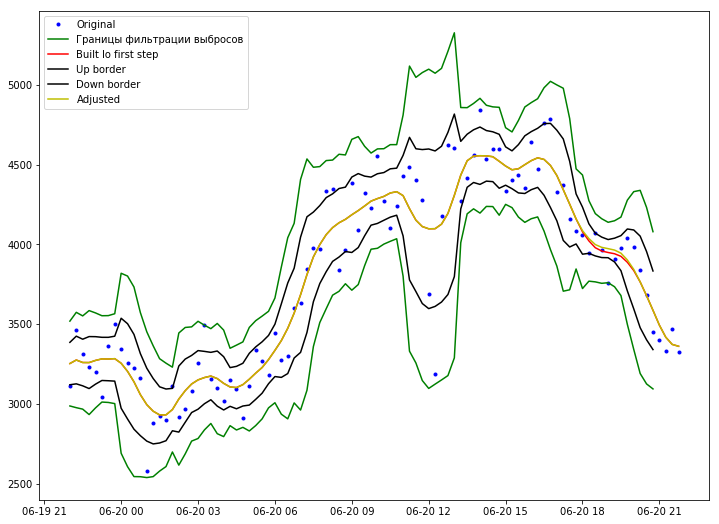

,Tinklabs,Tinklabs_lo,Tinklabs_std_first_step,Tinklabs_adj,Tinklabs_adj_first_step,Tinklabs_std
rep_date,,,,,,
2018-06-19 22:00:00,352.0,295.307794,77.847929,295.307794,352.0,77.847929
2018-06-19 22:15:00,187.0,247.549210,74.868997,247.549210,187.0,74.868997
2018-06-19 22:30:00,183.0,217.271943,70.827087,217.271943,183.0,70.827087
2018-06-19 22:45:00,154.0,196.884704,66.038814,196.884704,154.0,66.038814
2018-06-19 23:00:00,216.0,186.130625,31.843086,186.130625,216.0,31.843086


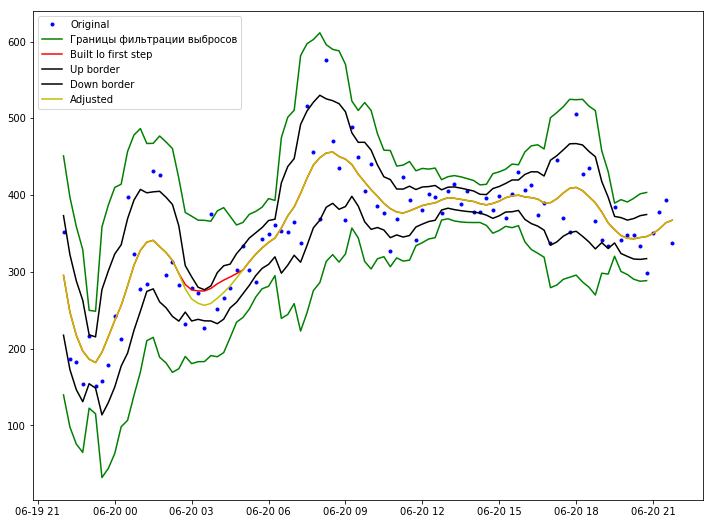

In [50]:
#Задаем необходимые переменные
#Window для расчета скользящего стандартного отклонения берем как, например, 1/12 от периода

v_window=8

i=df_source.index.shape[0]
x=np.linspace(-10,10,i)

#Вспомогательная функция для отсечения значений, выходящих за границы одного стандартного отклонения

def f(x):
    name=x.index[0]
    if x[name] > x[name+'_lo']+2*x[name+'_std_first_step']:
        x[name+'_adj']=np.nan
    elif x[name] < x[name+'_lo']-2*x[name+'_std_first_step']:
        x[name+'_adj']=np.nan
    else:
        x[name+'_adj']=x[name]
    return x

#Функция для обработки данных.
#На вход функции подается объект Series из исходных данных.
#На выходе получаем данные с отсеченными выбросами ['lo'] и со стандартным отколонением для обработанных данных ['std'].

def f_low(df_x):
    df_res=DataFrame(df_x)
    name=df_res.columns[0]
    i=df_x.index.shape[0]
    x=np.linspace(-10,10,i)
    df_res[name+'_lo'] = lo.lowess(x, df_x.values, x)
    df_res[name+'_std_first_step'] = df_x.rolling(window=v_window,min_periods=0).std().fillna(method='bfill').shift(-int(v_window/2))
    df_res=df_res.apply(f,axis=1)
    df_res[name+'_adj_first_step']=df_res[name+'_adj'].fillna(method='bfill')
    df_res[name+'_adj'] = lo.lowess(x, np.array(df_res[name+'_adj_first_step']), x)
    df_res[name+'_std'] = df_res[name+'_adj_first_step'].rolling(window=v_window,min_periods=0).std().fillna(method='bfill').shift(-int(v_window/2))
    return df_res

l=list(df_source.columns)
print(l)

for name in l:

    df=f_low(df_source[name])
    display(df.head())

    fig,ax = plt.subplots(1,figsize=(12,9))
    ax.plot(df[name],'b.',label='Original') #исходный график
    ax.plot(df[name+'_lo']+2*df[name+'_std_first_step'],'g',label='Границы фильтрации выбросов') #Верхняя граница для фильтрации выборосов
    ax.plot(df[name+'_lo']-2*df[name+'_std_first_step'],'g',label='Границы фильтрации выбросов') #Нижняя граница для фильтрации выборосов
    ax.plot(df[name+'_lo'],'r', label='Built lo first step') #восстановленный график методом lowess
    ax.plot(df[name+'_adj']+df[name+'_std'],'k', label='Up border') #Верхняя граница
    ax.plot(df[name+'_adj']-df[name+'_std'],'k', label='Down border') #Нижняя граница
    ax.plot(df[name+'_adj'],'y', label='Adjusted') #восстановленный график методом lowess
    plt.legend()
    plt.show()

Замечание для дальнейшей работы.
Если брать несколько периодов, то lowess сглаживает вершины периодов и хорошего усреднения трафика не получается.
Нужно брать один (или два) период и накладывать периоды друг на друга.